# Generate Synthetic Data

In [1]:
import numpy as np
from data_code.synthetic_data import generate_hmm_data

# Example usage
T = 100008
D = 1
num_states = 2
startprob = np.array([1/num_states for i in range(num_states)])  # initial state probabilities

######################################################################################################################
transition_probs = np.array([[0.96, 0.04],
                             [0.04, 0.96]])

# Define t-distribution parameters
# (df, loc, scale)
t_params = [
    {'df': 2.5, 'loc': np.full(D, -0.001), 'shape': np.eye(D) * 0.003**2},
    {'df': 2.5, 'loc': np.full(D, 0.001), 'shape': np.eye(D) * 0.003**2},
]

S, X = generate_hmm_data(T=T, 
                         D=D, 
                         num_states=num_states, 
                         startprob=startprob,
                         transition_probs=transition_probs,
                         emission_dist='t',
                         hmm_params=t_params,
                         clip_factor=10.0)

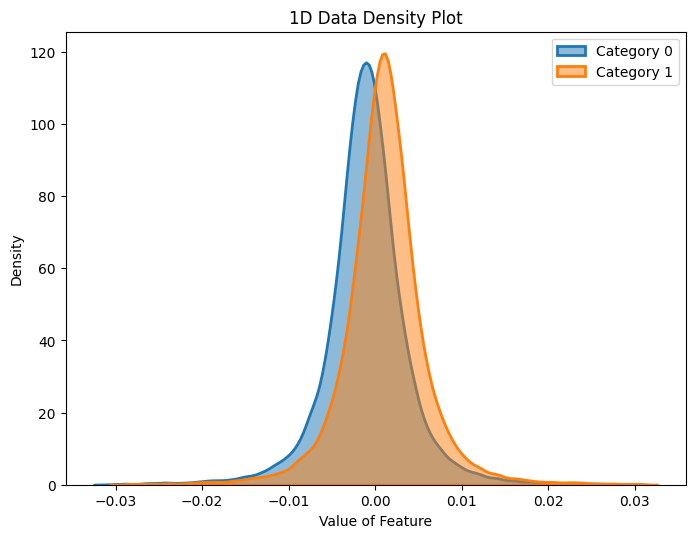

In [2]:
from utils.visualize import plot_clusters

plot_clusters(
    data=X,
    cluster_labels=S,
    title="1D Data Density Plot",
)

# Create Dataloader

In [3]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 500
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

# Create Mixture-VAE Model and fit it

In [4]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 1.0
    hard = False
    transition = 'jump'
    lamda_m = 4.0
    lamda_i = 4.0
    lamda_t = 4.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [5]:
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=500)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy: {vae_bal_acc:.4f}")

Epoch [20/500], VAE Loss: 11348.6245
Epoch [40/500], VAE Loss: 10845.1508
Epoch [60/500], VAE Loss: 10525.2371
Epoch [80/500], VAE Loss: 10365.1857
Epoch [100/500], VAE Loss: 10276.0135
Epoch [120/500], VAE Loss: 10212.9000
Epoch [140/500], VAE Loss: 10182.0033
Epoch [160/500], VAE Loss: 10117.7155
Epoch [180/500], VAE Loss: 10112.0000
Epoch [200/500], VAE Loss: 10055.1871
Epoch [220/500], VAE Loss: 10054.6837
Epoch [240/500], VAE Loss: 10041.5872
Epoch [260/500], VAE Loss: 10031.1734
Epoch [280/500], VAE Loss: 10041.6096
Epoch [300/500], VAE Loss: 9974.0648
Epoch [320/500], VAE Loss: 9989.9132
Epoch [340/500], VAE Loss: 9960.2008
Epoch [360/500], VAE Loss: 9971.3104
Epoch [380/500], VAE Loss: 9946.6254
Epoch [400/500], VAE Loss: 9964.1151
Epoch [420/500], VAE Loss: 9951.2158
Epoch [440/500], VAE Loss: 9931.4100
Epoch [460/500], VAE Loss: 9941.7339
Epoch [480/500], VAE Loss: 9926.5940
Epoch [500/500], VAE Loss: 9927.1275
[VAE] Balanced Accuracy: 0.6727


# Visualization

In [6]:
# Get the embeddings
num = 8
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

## plot the clusters in the original space

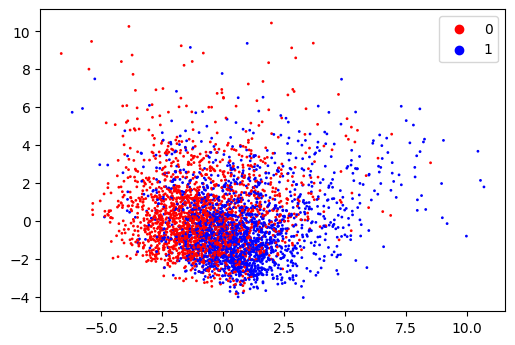

In [7]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

## plot the clusters in the latent space

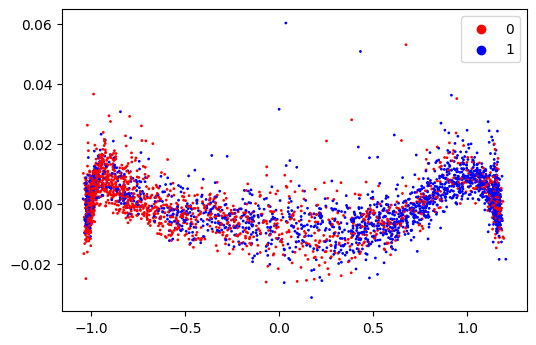

In [8]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1
)

# Other Models

## Jump Model

In [9]:
from model.jump_module import JumpModule

jump_penalty = 100.0
jump = JumpModule(num_states, jump_penalty=jump_penalty, max_iter=100)
jump.fit(train_loader)
true_s_test_jump, pred_s_test_jump = jump.inference(test_loader)

jump_bal_acc = balanced_accuracy(true_s_test_jump.ravel(), pred_s_test_jump.ravel(), n_classes = num_states)
print(f"[Jump] Balanced Accuracy: {jump_bal_acc:.4f}")

[Jump] Balanced Accuracy: 0.5237


## KMeans++

In [10]:
from model.kmeans_module import KMeansModule

kmeans = KMeansModule(n_clusters=num_states, n_init=10, max_iter=300)
kmeans.fit(train_loader)
true_s_test_kmeans, pred_s_test_kmeans = kmeans.inference(test_loader)

kmeans_bal_acc = balanced_accuracy(true_s_test_kmeans.ravel(), pred_s_test_kmeans.ravel(), n_classes = num_states)
print(f"[KMeans] Balanced Accuracy: {kmeans_bal_acc:.4f}")

[KMeans] Balanced Accuracy: 0.5018


## Gaussian-HMM

In [11]:
from model.hmm_module import GaussianHMMModule

hmm_model = GaussianHMMModule(n_components=num_states, covariance_type='full', n_iter=100, random_state=42)
hmm_model.fit(train_loader)
true_s_test_hmm, pred_s_test_hmm = hmm_model.inference(test_loader)

# Evaluation
hmm_bal_acc = balanced_accuracy(true_s_test_hmm.ravel(), pred_s_test_hmm.ravel(), n_classes = num_states)
print(f"[HMM] Balanced Accuracy: {hmm_bal_acc:.4f}")

[HMM] Balanced Accuracy: 0.5028
